In [19]:
#first lets see where the cifar 10 dataset is, hopefully in torchvision
import torch, torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

print(f"Torch version: {torch.__version__}, Torchvision version: {torchvision.__version__}")
 



Torch version: 2.7.1, Torchvision version: 0.24.0


In [20]:
#next some device agnostic code:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(device)

cuda


In [21]:
#lets get our paths in order using pathlib
from pathlib import Path
from datetime import datetime

MODEL_NAME = "CIFAR10"
EXPERIMENT_NAME = "EXP_1"

now = datetime.now()
TIMESTAMP = f"{now.month}-{now.day}-{str(now.year)[-2:]}-@-{now.strftime('%I_%M_%S%p')}"

BASE_DIR = Path(MODEL_NAME)

DATA_DIR = BASE_DIR / "data"
EXPERIMENT_DIR = BASE_DIR / EXPERIMENT_NAME

#OTHER DIRS
MODEL_DIR = EXPERIMENT_DIR / "models"
GRAPHS_DIR = EXPERIMENT_DIR / "graphs"
RESULTS_DIR = EXPERIMENT_DIR / "results"
LOSS_DIR = GRAPHS_DIR / "loss"
ACCURACY_DIR = GRAPHS_DIR / "accuracy"

#now to make the directories

for directory in [MODEL_DIR,GRAPHS_DIR,RESULTS_DIR,LOSS_DIR,ACCURACY_DIR,DATA_DIR]:
    directory.mkdir(parents=True,exist_ok=True)

MODEL_PATH = MODEL_DIR / f"{MODEL_NAME}-{EXPERIMENT_NAME}-{TIMESTAMP}"
RESULTS_PATH = RESULTS_DIR / f"{MODEL_NAME}-{EXPERIMENT_NAME}-{TIMESTAMP}"
LOSS_GRAPH_PATH = LOSS_DIR / f"{MODEL_NAME}-{EXPERIMENT_NAME}-{TIMESTAMP}"
ACC_GRAPH_PATH = ACCURACY_DIR / f"{MODEL_NAME}-{EXPERIMENT_NAME}-{TIMESTAMP}"


In [22]:
import torchvision.transforms as transforms

transform_upscale = transforms.Compose([
    transforms.Resize((224, 224)),   #upsample from 32x32
    transforms.ToTensor(),
])

In [23]:
#now, lets load the data
train_data = CIFAR10(
    root = DATA_DIR,
    train = True,
    transform=transform_upscale,
    download=True
)
test_data = CIFAR10(
    root = DATA_DIR,
    train = False,
    transform = transform_upscale,
    download =True
)

In [24]:
len(train_data) #returns 50000, or the size of the training set
len(test_data) #10000 size of testing data
type(train_data[0]) #this is a tuple
len(train_data[0]) #size two tuple
train_data[0][0] #the tensor object, torch.tensor
train_data[0][1] #this is a class, namely the class 6
train_data[0][0].shape #shape is 3,32,32 or im guessing RGB,then rows(height) then cols(width)

image, label = train_data[0]
image.shape #3,32,32


torch.Size([3, 224, 224])

In [25]:
len(train_data.data), len(train_data.targets)

#as for the names of the classes:
classes = train_data.classes
len(classes) #10 classes total
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Image shape: torch.Size([3, 224, 224])


Text(0.5, 1.0, 'Image 0, Class: frog')

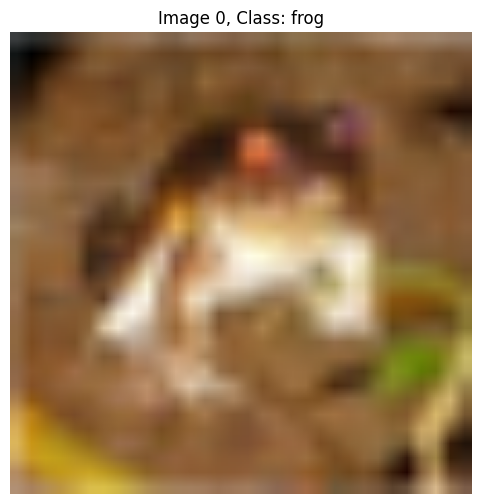

In [26]:
#plot some of the images using matplotlib imshow, which takes 2d array of values and graphs it
#WHEN PLOTING, MUST BE H, W, C
import matplotlib.pyplot as plt
image,label = train_data[0]
print(f"Image shape: {image.shape}")
plt.figure(figsize=(10,6))
plt.imshow(image.permute(1,2,0)) #remember to permute so height,width,channels
plt.axis(False)
plt.title(f"Image {0}, Class: {classes[label]}")

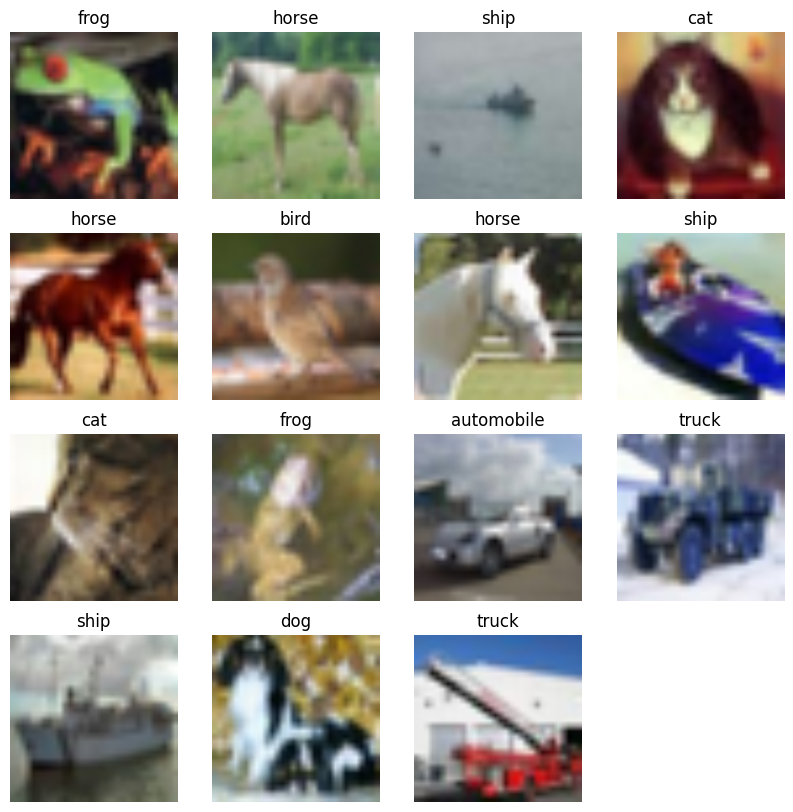

In [27]:
#code to plot a 2d array of images:

rows,cols = 4,4
torch.manual_seed(42)
plt.figure(figsize=(10,10))

#will be from 0 inclusive to rows * cols exclusive
for i in range (1,rows*cols,1):
    plt.subplot(rows,cols,i)
    image,label = train_data[torch.randint(low=0,high=len(train_data),size=[1]).item()]#returns the actual tuple
    plt.imshow(image.permute(1,2,0))
    plt.title(classes[label])
    plt.axis(False)



In [28]:
#getting the dataloaders ready:

BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(dataset=test_data,batch_size=BATCH_SIZE)

len(train_dataloader), len(test_dataloader)

(1563, 313)

In [29]:
#now lets make the model:

model = models.AlexNet(num_classes=len(classes))
model.state_dict



<bound method Module.state_dict of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=92

In [39]:
#now the loss function and optimizer
from torchmetrics.classification import Accuracy

loss_fn = torch.nn.CrossEntropyLoss() #logit based
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)


In [31]:
#homemade accuracy function:
def accuracy_function(predicted_batch_labels: torch.Tensor,actual_batch_labels: torch.Tensor):
    number_correct = torch.eq(predicted_batch_labels,actual_batch_labels).sum().item()
    return (number_correct / len(predicted_batch_labels)) * 100

In [32]:
#Now, lets make predictions and get Model_0 results:
torch.manual_seed(42)
def evaluate_model(model: torch.nn.Module,dataloader: torch.utils.data.DataLoader,loss_funct: torch.nn.Module,accuracy_funct):
    #the goal of this method is to standardize model comparisons, so lets take the model, use teh dataloader to do a forward pass through the
    #data for everything in the dataloader, then calculat ethe loss and accuracy after every batch, and see whats up
    #returns a dictionary with the results:
    epoch_loss,epoch_acc = 0,0
    model.eval()
    with torch.inference_mode():
        #only doing one epoch, so:

        for (batch_evaluation_features,batch_evaluation_labels) in test_dataloader:
            y_eval_logit_preds = model(batch_evaluation_features) #where output is (32,10)
            #NOTE:ERRLOG:Dimension out of range (expected to be in range of [-1, 0], but got 1)
            # -1 dim means infer, and 0 means 0, but it got dim1, essentiall there is a tensor size problem
            #problem was that you wrote argmax instead of softmax
            y_eval_preds = torch.softmax(y_eval_logit_preds,dim=1).argmax(dim=1) #size (32,) with prediction indexes

            batch_eval_loss = loss_funct(y_eval_logit_preds,batch_evaluation_labels).detach().cpu().numpy()
            batch_eval_acc = accuracy_funct(y_eval_preds,batch_evaluation_labels)

            epoch_loss += batch_eval_loss
            epoch_acc += batch_eval_acc
        epoch_loss /= len(dataloader)
        epoch_acc /= len(dataloader)


        #can use teh __class__.__name__ to return just the name of the class
        results_dict = {
            "model_name": f"{model.__class__.__name__}",
            "model_loss": epoch_loss,
            "model_accuracy": epoch_acc
        }
        return results_dict
    
#NOTE: to pass a function, dont put the parenthesis after it, thats for calling it
model_0_results = evaluate_model(model=model,dataloader=test_dataloader,loss_funct=loss_fn,accuracy_funct=accuracy_function)
model_0_results

KeyboardInterrupt: 

In [40]:
import torchmetrics

def train_step(model, dataloader, loss_funct, optimizer, accuracy_obj_training, device):
    model.train()
    accuracy_obj_training.reset()

    epoch_loss = 0.0

    for training_batch_features, training_batch_labels in dataloader:
        training_batch_features = training_batch_features.to(device)
        training_batch_labels   = training_batch_labels.to(device)

        y_train_logit_preds = model(training_batch_features)       # (B, num_classes)
        y_train_preds = torch.softmax(y_train_logit_preds, dim=1).argmax(dim=1)

        batch_train_loss = loss_funct(y_train_logit_preds, training_batch_labels)

        epoch_loss += batch_train_loss.item()
        accuracy_obj_training.update(y_train_preds, training_batch_labels)

        optimizer.zero_grad()
        batch_train_loss.backward()
        optimizer.step()

    epoch_loss /= len(dataloader)
    accuracy = accuracy_obj_training.compute().item()

    return {"Training Loss": epoch_loss, "Training Accuracy": accuracy}


def test_step(model, dataloader, loss_funct, accuracy_test_obj, device):
    model.eval()
    accuracy_test_obj.reset()

    epoch_loss = 0.0

    with torch.inference_mode():
        for testing_batch_features, testing_batch_labels in dataloader:
            testing_batch_features = testing_batch_features.to(device)
            testing_batch_labels   = testing_batch_labels.to(device)

            y_test_logit_preds = model(testing_batch_features)
            y_test_preds = torch.softmax(y_test_logit_preds, dim=1).argmax(dim=1)

            test_batch_loss = loss_funct(y_test_logit_preds, testing_batch_labels)

            epoch_loss += test_batch_loss.item()
            accuracy_test_obj.update(y_test_preds, testing_batch_labels)

    epoch_loss /= len(dataloader)
    accuracy = accuracy_test_obj.compute().item()

    return {"Testing Loss": epoch_loss, "Testing Accuracy": accuracy}


In [41]:
#Now, lets impliment a save checkpoint function to save the state of where we were. Best way is to use the torch.save to save a dict that contains the 
#epoch, model's state dict, and optimizer's state dict

def save_checkpoint(epoch: int, model: torch.nn.Module, optimizer: torch.optim.Optimizer, checkpoint_dir: Path):
    

    checkpoint_name = f"CHECKPOINT_{MODEL_NAME}_{EXPERIMENT_NAME}_{TIMESTAMP}_FOR_EPOCH_{epoch}"
    checkpoint_path = checkpoint_dir / checkpoint_name

    checkpoint = {
        "Epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }
    torch.save(obj=checkpoint,f=checkpoint_path)
    print(f"Successfully Saved Checkpoint at Epoch {epoch}")


In [42]:
#now, the train, test loop using our helper functions

from tqdm import tqdm
from timeit import default_timer as timer 
import csv

#
epochs = 100
gpu_start_time = timer()
model.to(device)

with open(file=RESULTS_PATH,mode="w",newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch","Training Loss","Testing Loss","Training Accuracy","Testing Accuracy"])

    for epoch in tqdm(range(epochs)):
        #create the accuracy objects:
        training_accuracy_object = torchmetrics.classification.Accuracy(task="MULTICLASS",num_classes=len(classes)).to(device)
        testing_accuracy_object = torchmetrics.classification.Accuracy(task="MULTICLASS",num_classes=len(classes)).to(device)

        train_results = train_step(model = model,dataloader=train_dataloader,loss_funct=loss_fn,optimizer=optimizer,accuracy_obj_training=training_accuracy_object,device=device)

        test_results = test_step(model=model,dataloader=test_dataloader,loss_funct=loss_fn,accuracy_test_obj=testing_accuracy_object,device=device)

        #Now, lets try to impliment an evaluate, save_checkpoint every 10 epochs, and also dont forget to write to the results file

        writer.writerow([epoch,train_results["Training Loss"],test_results["Testing Loss"],train_results["Training Accuracy"],test_results["Testing Accuracy"]])

        print(f"Epoch: {epoch} | Training Loss: {train_results['Training Loss']} | Testing Loss: {test_results['Testing Loss']} | Training Accuracy: {train_results['Training Accuracy']} | Testing Accuracy: {test_results['Testing Accuracy']}")

        if epoch % 10 == 0:
            save_checkpoint(model=model,optimizer=optimizer,checkpoint_dir=MODEL_DIR,epoch=epoch)
            
    
    
    #use the save_checkpoint builtin to save every 10 epochs:




  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | Training Loss: nan | Testing Loss: nan | Training Accuracy: 0.09982000291347504 | Testing Accuracy: 0.10000000149011612


  1%|          | 1/100 [00:28<46:50, 28.39s/it]

Successfully Saved Checkpoint at Epoch 0


  2%|▏         | 2/100 [00:56<46:26, 28.44s/it]

Epoch: 1 | Training Loss: nan | Testing Loss: nan | Training Accuracy: 0.10000000149011612 | Testing Accuracy: 0.10000000149011612


  2%|▏         | 2/100 [01:12<59:01, 36.14s/it]


KeyboardInterrupt: 

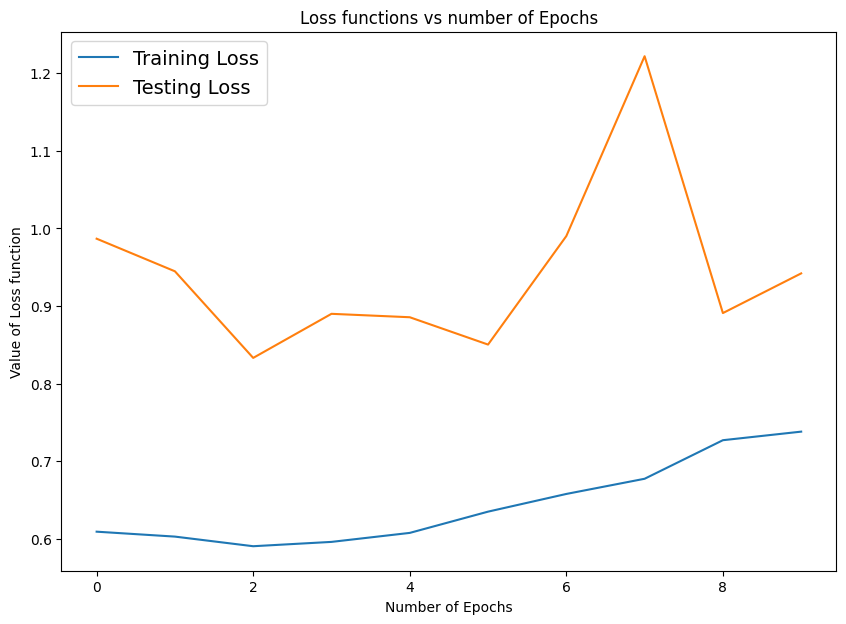

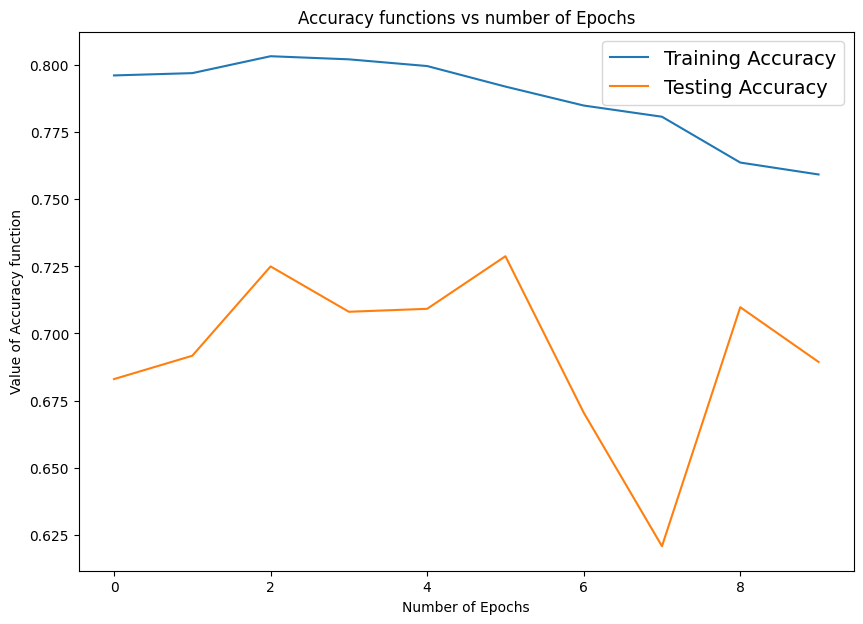

In [ ]:
data = pd.read_csv(filepath_or_buffer=RESULTS_PATH)

plt.figure(figsize=(10,7))
plt.plot(data["Epoch"],data["Training Loss"],label="Training Loss")
plt.plot(data["Epoch"],data["Testing Loss"],label="Testing Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Value of Loss function")
plt.title("Loss functions vs number of Epochs")
plt.legend(prop={"size":14})
plt.savefig(LOSS_GRAPH_PATH)
plt.show()
plt.close()

plt.figure(figsize=(10,7))
plt.plot(data["Epoch"],data["Training Accuracy"],label="Training Accuracy")
plt.plot(data["Epoch"],data["Testing Accuracy"],label="Testing Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Value of Accuracy function")
plt.title("Accuracy functions vs number of Epochs")
plt.legend(prop={"size":14})
plt.savefig(ACC_GRAPH_PATH)
plt.show()
plt.close()